<a href="https://colab.research.google.com/github/WeiShengL/Machine-Learning/blob/main/Week4_AutoencoderChallenge_(19107650).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practical Machine Learning for Physicists
## Week 2 Exercise - Part 2
## Deadline Monday 9th November at 12pm (Noon)
*Lai Wei Sheng. S/N:19107650*

For both of these tasks we want you to implement autoencoder networks that:
- Train on randomly generated circles (using the circle_generator function below)
- Use 27x27 pixel images
- Use no more than 30,000 randomly generated samples (e.g. batchsize 30 and 1000 steps, or batchsize 1000 and 30 steps, or anywhere inbetween) in training the final networks for each task
- Use the mean_squared_error loss function
- Fulfil the network size requirement listed in the task (can be verifired using the print_layers function, after the network is partially trained)

### Task 1:
Implement any network design, but the bottleneck must contain no more than 9 neurons.

### Task 2:
Implement any network design, but the bottleneck must contain no more than 3 neurons.



#### Practicalities
You should use this notebook for your work and upload it to both Moodle and CoCalc. You are expected to use TensorFlow and Keras to complete these tasks. The notebook should be self-contained and able to be executed if necessary. Marks will be awarded for (roughly equally weighted):
- Overall notebook clarity (both in terms of good coding practice and coherent discussion)
- Task 1 performance (0.02 is a good target cost to do better than)
- Task 2 performance ( a good target here is left for the student to determine)



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math

import matplotlib.style #Some style nonsense
import matplotlib as mpl #Some more style nonsense

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

#Set default figure size
mpl.rcParams['figure.figsize'] = [12.0, 8.0] #Inches... of course it is inches
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=200 # dots per inch


In [2]:
#A big messy function to do the training
# model -- our keras neural model autoencoder
# image_generator -- a function to generate random images for the training (see below for examples)
# img_size -- the size of our image in pixels
# batchsize -- the number of images to include in each training batch
# steps -- the number of steps taken in the training
#
# returns an array of the costs
def generate_and_train(model,image_generator,img_size,batchsize,steps):
   
    #Generate an array of the numbers 1 to img_size and create a meshgrid from them    
    pixels=np.linspace(-1,1,img_size)
    x,y=np.meshgrid(pixels,pixels)
    
    #Now create a test image using 1 call to image_generator
    #y_test=np.zeros([1,pixels,pixels,1])
    #y_test[:,:,:,0]=image_generator(1,x,y)
    
    #Now create the empty arrays for the images and cost
    y_in=np.zeros([batchsize,img_size,img_size,1])
    y_target=np.zeros([batchsize,img_size,img_size,1])
    cost=np.zeros(steps)
    
    #Loop through the steps, get a random batch of samples, train the model, repeat
    for k in range(steps):
        # produce samples:
        y_in[:,:,:,0]=image_generator(batchsize,x,y)
        y_target=np.copy(y_in) # autoencoder wants to reproduce its input!
        
        # do one training step on this batch of samples:
        cost[k]=model.train_on_batch(y_in,y_target)
    
    return cost,y_target

def get_test_image(image_generator,img_size):
    #Generate an array of the numbers 1 to img_size and create a meshgrid from them    
    pixels=np.linspace(-1,1,img_size)
    x,y=np.meshgrid(pixels,pixels)
    
    #Now create a test image using 1 call to image_generator
    y_test=np.zeros([1,img_size,img_size,1])
    y_test[:,:,:,0]=image_generator(1,x,y)
    return y_test

# A function to generate and plot a single test image and the output of our model
# only to be called after training the model
def plot_test_image(model,image_generator,img_size):
    #Get random test image
    y_test=get_test_image(image_generator,img_size)
    
    #Create the output image
    y_test_out=model.predict_on_batch(y_test)
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(y_test[0,:,:,0],origin='lower')
    ax[0].set_title("Input")
    ax[1].imshow(y_test_out[0,:,:,0],origin='lower')
    ax[1].set_title("Output")
    
def print_layers(network, y_in):
    """
    Call this on some test images y_in, to get a print-out of
    the layer sizes. Shapes shown are (batchsize,pixels,pixels,channels).
    After a call to the visualization routine, y_target will contain
    the last set of training images, so you could feed those in here.
    """
    layer_features=get_layer_activations(network,y_in)
    #print(layer_features)
    for idx,feature in enumerate(layer_features):
        s=np.shape(feature)
        print("Layer "+str(idx)+": "+str(s[1]*s[2]*s[3])+" neurons / ", s)

def get_layer_activation_extractor(network):
    #print(network.inputs)
    #for layer in network.layers:
    #    print(layer.output)
    return(keras.Model(inputs=network.inputs,
                            outputs=[layer.output for layer in network.layers]))

def get_layer_activations(network, y_in):
    """
    Call this on some test images y_in, to get the intermediate 
    layer neuron values. These are returned in a list, with one
    entry for each layer (the entries are arrays).
    """
    extractor=get_layer_activation_extractor(network)
    #print(extractor)
    layer_features = extractor(y_in)
    return layer_features
    

## Circle generator


In [3]:
# A simple image generator that returns an array of batchsize images
# each image has a size of x * y pixels
# in this image each image has a randomly placed circle (and the circle is of random size)
def circle_generator(batchsize,x,y):
    R=np.random.uniform(size=batchsize)
    x0=np.random.uniform(size=batchsize,low=-1,high=1)
    y0=np.random.uniform(size=batchsize,low=-1,high=1)
    return( 1.0*((x[None,:,:]-x0[:,None,None])**2 + (y[None,:,:]-y0[:,None,None])**2 < R[:,None,None]**2) )


## Model Structure

In [4]:
model=keras.models.Sequential()

model.add(keras.layers.Conv2D(256,5,input_shape=(None,None,1),activation="sigmoid",padding='same')) # Convolutional Layer
model.add(keras.layers.AveragePooling2D(pool_size=(3,3),padding='same'))                            # down pooling

model.add(keras.layers.Conv2D(128,5,activation="sigmoid",padding='same'))                           # Convolutional layer
model.add(keras.layers.AveragePooling2D(pool_size=(3,3),padding='same'))                            # down pooling

model.add(keras.layers.Conv2D(1,3,activation="sigmoid",padding='same'))                             # Convolutional layer (bottlenck with 9 nerurons)
model.add(keras.layers.UpSampling2D(size=(3,3)))                                                    # up sizing

model.add(keras.layers.Conv2D(64,5,activation="sigmoid",padding='same'))                            # Convolutional layer
model.add(keras.layers.UpSampling2D(size=(3,3)))                                                    # up sizing

model.add(keras.layers.Conv2D(128,5,activation="sigmoid",padding='same'))                           # Convolutional layer

model.add(keras.layers.Conv2D(256,5,activation="linear",padding='same'))                            # Convolutional layer

# Compiling Model
model.compile(loss='mean_squared_error',
              optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 256)   6656      
                                                                 
 average_pooling2d (AverageP  (None, None, None, 256)  0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 128)   819328    
                                                                 
 average_pooling2d_1 (Averag  (None, None, None, 128)  0         
 ePooling2D)                                                     
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 1)     1153      
                                                                 
 up_sampling2d (UpSampling2D  (None, None, None, 1)    0

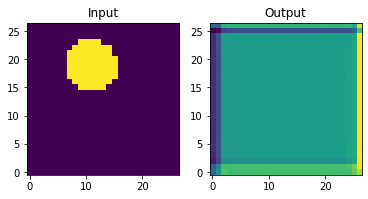

In [5]:
# Plot of model output before training
plot_test_image(model,circle_generator,27)

Final Cost = 0.1374


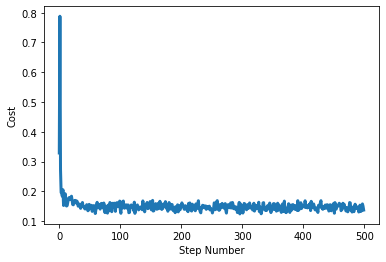

In [6]:
# Training model and plot cost value
steps = 500
cost,y_target = generate_and_train(model,circle_generator,27,100,steps)
fig, ax = plt.subplots()
stepArray=np.arange(steps) 
ax.plot(stepArray,cost,linewidth=3) 
ax.set_xlabel("Step Number") 
ax.set_ylabel("Cost")
print("Final Cost = {0:.4f}".format(cost[-1]))

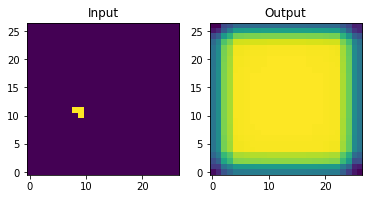

In [7]:
plot_test_image(model,circle_generator,27) # Plot input and output by model

In [8]:
print_layers(model, y_target) # Print Layers

Layer 0: 186624 neurons /  (100, 27, 27, 256)
Layer 1: 20736 neurons /  (100, 9, 9, 256)
Layer 2: 10368 neurons /  (100, 9, 9, 128)
Layer 3: 1152 neurons /  (100, 3, 3, 128)
Layer 4: 9 neurons /  (100, 3, 3, 1)
Layer 5: 81 neurons /  (100, 9, 9, 1)
Layer 6: 5184 neurons /  (100, 9, 9, 64)
Layer 7: 46656 neurons /  (100, 27, 27, 64)
Layer 8: 93312 neurons /  (100, 27, 27, 128)
Layer 9: 186624 neurons /  (100, 27, 27, 256)


## Task 2

For a bottleneck of 3 neurons we will have to add an additional layer for down pooling the input.

In [9]:
model2=keras.models.Sequential()

model2.add(keras.layers.Conv2D(256,5,input_shape=(None,None,1),activation="sigmoid",padding='same')) # Convolutional Layer
model2.add(keras.layers.AveragePooling2D(pool_size=(3,3),padding='same'))                            # down pooling

model2.add(keras.layers.Conv2D(128,5,activation="sigmoid",padding='same'))                           # Convolutional layer
model2.add(keras.layers.AveragePooling2D(pool_size=(3,3),padding='same'))                            # down pooling

model2.add(keras.layers.Conv2D(128,5,activation="relu",padding='same'))                              # Convolutional layer
model2.add(keras.layers.AveragePooling2D(pool_size=(3,3),padding='same'))                            # extra down pooling

model2.add(keras.layers.Conv2D(3,3,activation="sigmoid",padding='same'))                             # Convolutional layer
model2.add(keras.layers.UpSampling2D(size=(3,3)))                                                    # extra up sizing

model2.add(keras.layers.Conv2D(128,5,activation="sigmoid",padding='same'))                           # Convolutional layer
model2.add(keras.layers.UpSampling2D(size=(3,3)))                                                    # up sizing

model2.add(keras.layers.Conv2D(128,5,activation="sigmoid",padding='same'))                           # Convolutional layer
model2.add(keras.layers.UpSampling2D(size=(3,3)))                                                    # up sizing

model2.add(keras.layers.Conv2D(256,5,activation="sigmoid",padding='same'))                           # Convolutional layer

model2.add(keras.layers.Conv2D(512,3,activation="linear",padding='same'))                            # Convolutional layer

# Compiling Model
model2.compile(loss='mean_squared_error',
              optimizer='adam')
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, None, None, 256)   6656      
                                                                 
 average_pooling2d_2 (Averag  (None, None, None, 256)  0         
 ePooling2D)                                                     
                                                                 
 conv2d_7 (Conv2D)           (None, None, None, 128)   819328    
                                                                 
 average_pooling2d_3 (Averag  (None, None, None, 128)  0         
 ePooling2D)                                                     
                                                                 
 conv2d_8 (Conv2D)           (None, None, None, 128)   409728    
                                                                 
 average_pooling2d_4 (Averag  (None, None, None, 128) 

Final Cost = 0.1404


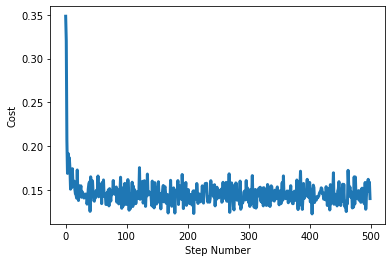

In [10]:
# Training model and plot cost value
steps = 500
cost,y_target = generate_and_train(model2,circle_generator,27,100,steps)
fig, ax = plt.subplots()
stepArray=np.arange(steps) 
ax.plot(stepArray,cost,linewidth=3) 
ax.set_xlabel("Step Number") 
ax.set_ylabel("Cost")
print("Final Cost = {0:.4f}".format(cost[-1]))

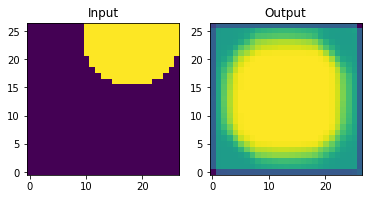

In [11]:
plot_test_image(model2,circle_generator,27) # Plot of input and output by model

In [12]:
print_layers(model2,y_target) # Print layers

Layer 0: 186624 neurons /  (100, 27, 27, 256)
Layer 1: 20736 neurons /  (100, 9, 9, 256)
Layer 2: 10368 neurons /  (100, 9, 9, 128)
Layer 3: 1152 neurons /  (100, 3, 3, 128)
Layer 4: 1152 neurons /  (100, 3, 3, 128)
Layer 5: 128 neurons /  (100, 1, 1, 128)
Layer 6: 3 neurons /  (100, 1, 1, 3)
Layer 7: 27 neurons /  (100, 3, 3, 3)
Layer 8: 1152 neurons /  (100, 3, 3, 128)
Layer 9: 10368 neurons /  (100, 9, 9, 128)
Layer 10: 10368 neurons /  (100, 9, 9, 128)
Layer 11: 93312 neurons /  (100, 27, 27, 128)
Layer 12: 186624 neurons /  (100, 27, 27, 256)
Layer 13: 373248 neurons /  (100, 27, 27, 512)


# Conclusion
There is no one perfect parameters configuration for the best model for network training. The bottleneck with only 3 neurons would have a higher cost value compare to the model with 9 neurons but it would have a higher efficiency. The network choice is highly dependent on the application of the network. Some would argue the cost value with a 3neurons bottleneck would be good enough for a trained model.

# Feedback

Should have used lesser amount of filter at the start for a general take of image then slightly increase the number of filter.

Example below

In [13]:
model=keras.models.Sequential()

model.add(keras.layers.Conv2D(32,5,input_shape=(None,None,1),activation="sigmoid",padding='same')) # Convolutional Layer
model.add(keras.layers.AveragePooling2D(pool_size=(3,3),padding='same'))                            # down pooling

model.add(keras.layers.Conv2D(64,5,activation="sigmoid",padding='same'))                           # Convolutional layer
model.add(keras.layers.AveragePooling2D(pool_size=(3,3),padding='same'))                            # down pooling

model.add(keras.layers.Conv2D(1,3,activation="sigmoid",padding='same'))                             # Convolutional layer (bottlenck with 9 nerurons)
model.add(keras.layers.UpSampling2D(size=(3,3)))                                                    # up sizing

model.add(keras.layers.Conv2D(64,5,activation="sigmoid",padding='same'))                            # Convolutional layer
model.add(keras.layers.UpSampling2D(size=(3,3)))                                                    # up sizing

model.add(keras.layers.Conv2D(32,5,activation="sigmoid",padding='same'))                           # Convolutional layer

model.add(keras.layers.Conv2D(32,5,activation="linear",padding='same'))                            # Convolutional layer

# Compiling Model
model.compile(loss='mean_squared_error',
              optimizer='adam')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, None, None, 32)    832       
                                                                 
 average_pooling2d_5 (Averag  (None, None, None, 32)   0         
 ePooling2D)                                                     
                                                                 
 conv2d_15 (Conv2D)          (None, None, None, 64)    51264     
                                                                 
 average_pooling2d_6 (Averag  (None, None, None, 64)   0         
 ePooling2D)                                                     
                                                                 
 conv2d_16 (Conv2D)          (None, None, None, 1)     577       
                                                                 
 up_sampling2d_5 (UpSampling  (None, None, None, 1)   

Final Cost = 0.0192


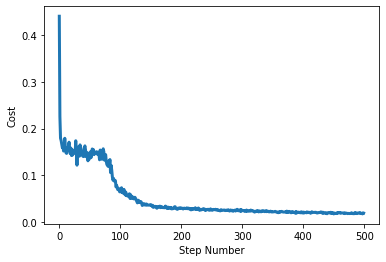

In [14]:
steps = 500
cost,y_target = generate_and_train(model,circle_generator,27,100,steps)
fig, ax = plt.subplots()
stepArray=np.arange(steps) 
ax.plot(stepArray,cost,linewidth=3) 
ax.set_xlabel("Step Number") 
ax.set_ylabel("Cost")
print("Final Cost = {0:.4f}".format(cost[-1]))

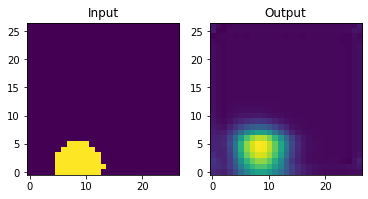

In [16]:
plot_test_image(model,circle_generator,27) # Plot input and output by model